In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10,6
from pandas import read_csv
from pandas import datetime
from datetime import datetime

In [2]:
dataset = pd.read_csv('medicare_enrollment.csv')
#Parse strings to datetime type
dataset['Year'] = pd.to_datetime(dataset['Year'], format ='%Y', infer_datetime_format=True)
indexedDataset = dataset.set_index(['Year'])

In [3]:
indexedDataset.keys()

Index(['Total'], dtype='object')

In [4]:
dataset.dtypes

Year     datetime64[ns]
Total             int64
dtype: object

In [5]:
indexedDataset.tail()

,Total
Year,
2014-01-01,52005389
2015-01-01,53499449
2016-01-01,55330965
2017-01-01,56800280
2018-01-01,59869402


C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


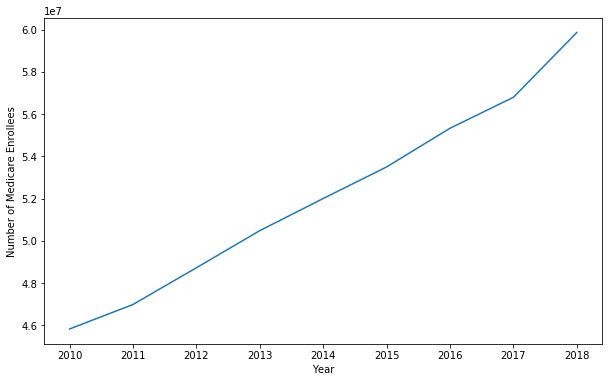

In [6]:
plt.xlabel("Year")
plt.ylabel("Number of Medicare Enrollees")
plt.plot(indexedDataset)

In [7]:
rolmean = indexedDataset.rolling(window=1).mean()
# window = 12 is the number of months / used 1 for 1 year
rolstd = indexedDataset.rolling(window=1).std()
print(rolmean,rolstd)

                 Total
Year                  
2010-01-01  45826207.0
2011-01-01  46984250.0
2012-01-01  48722929.0
2013-01-01  50484675.0
2014-01-01  52005389.0
2015-01-01  53499449.0
2016-01-01  55330965.0
2017-01-01  56800280.0
2018-01-01  59869402.0             Total
Year             
2010-01-01    NaN
2011-01-01    NaN
2012-01-01    NaN
2013-01-01    NaN
2014-01-01    NaN
2015-01-01    NaN
2016-01-01    NaN
2017-01-01    NaN
2018-01-01    NaN


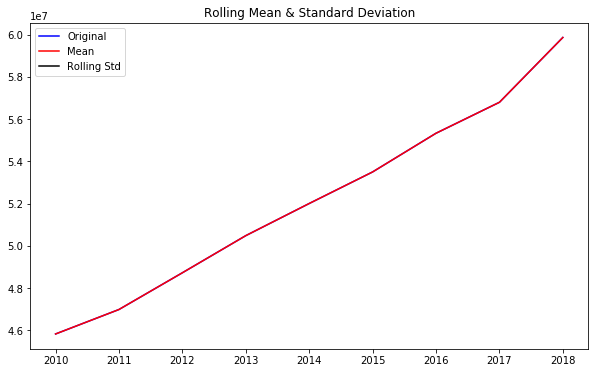

In [8]:
#Plot rolling stats

orig = plt.plot(indexedDataset, color='blue', label= 'Original')
mean = plt.plot(rolmean, color='red', label= 'Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc ='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [10]:
#Perform Dickey-Fuller test:
from statsmodels.tsa.stattools import adfuller

print("Results from Dickey-Fuller Test:")
dftest = adfuller(indexedDataset['Total'], autolag='AIC')
      
dfoutput = pd.Series(dftest[0:4], index=['Test Stastic', 'p-value', '#Lag Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
      dfoutput['Critial Value (%s)'%key] = value
      
print(dfoutput)

#shows data is not stationary

Results from Dickey-Fuller Test:
Test Stastic                   1.881319
p-value                        0.998497
#Lag Used                      0.000000
Number of Observations Used    8.000000
Critial Value (1%)            -4.665186
Critial Value (5%)            -3.367187
Critial Value (10%)           -2.802961
dtype: float64


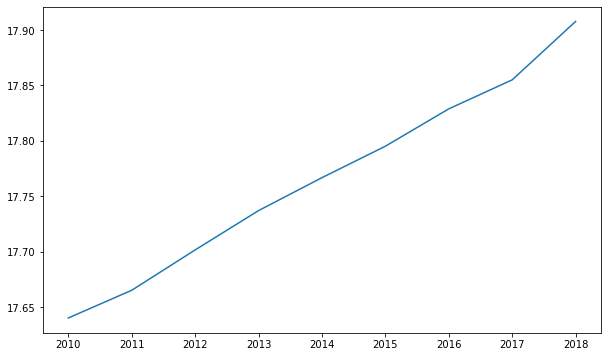

In [11]:
#Estimating Trend
indexedDataset_logScale = np.log(indexedDataset)
plt.plot(indexedDataset_logScale)

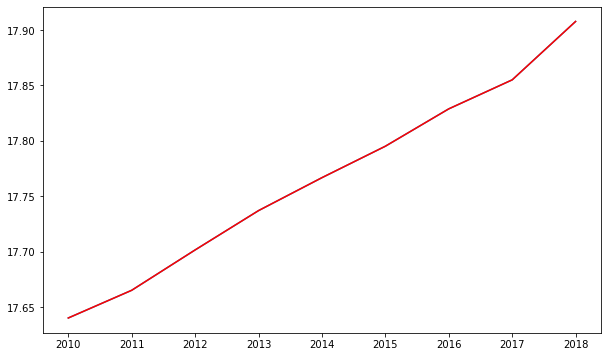

In [12]:
movingAverage = indexedDataset_logScale.rolling(window=1).mean()
movingSTD = indexedDataset_logScale.rolling(window=1).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [13]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(5)

#remove Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(3)


# sometimes you want the log, sometimes square, sometimes cubed root

,Total
Year,
2010-01-01,0.000000e+00
2011-01-01,0.000000e+00
2012-01-01,3.552714e-15


In [14]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    # Determining rolling statistics:
    movingAverage = timeseries.rolling(window=1).mean()
    movingSTD = timeseries.rolling(window=1).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage,color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Stastic                   1.881319
p-value                        0.998497
#Lag Used                      0.000000
Number of Observations Used    8.000000
Critial Value (1%)            -4.665186
Critial Value (5%)            -3.367187
Critial Value (10%)           -2.802961
dtype: float64


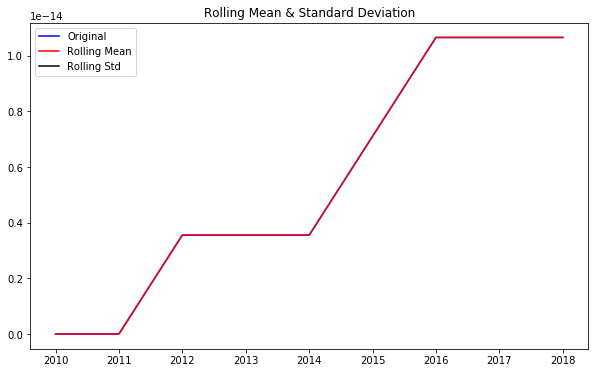

Results of Dickey-Fuller Test:


In [15]:
test_stationarity(datasetLogScaleMinusMovingAverage)

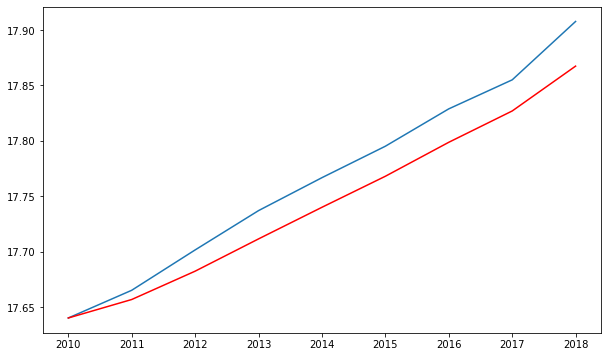

In [16]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=1, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

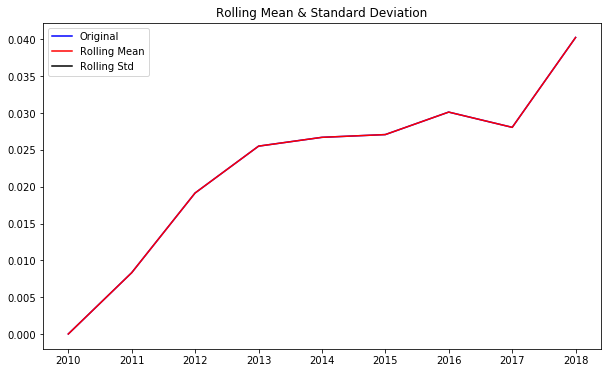

Results of Dickey-Fuller Test:


In [17]:
datasetLogScaleMinusMovingExponentialDecayAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

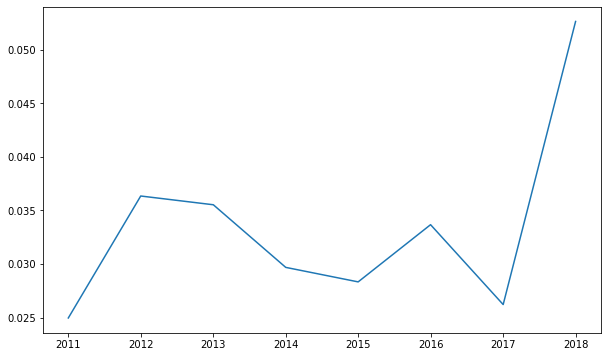

In [18]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift()
plt.plot(datasetLogDiffShifting)

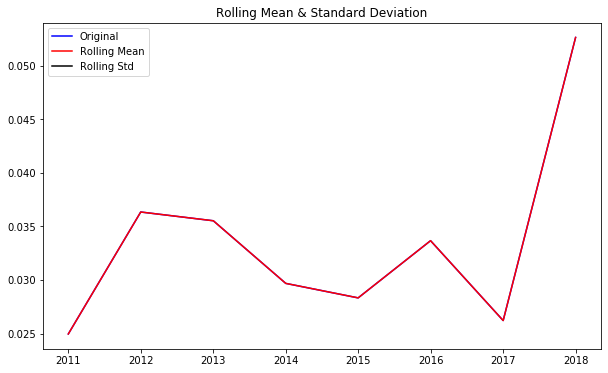

Results of Dickey-Fuller Test:


In [19]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

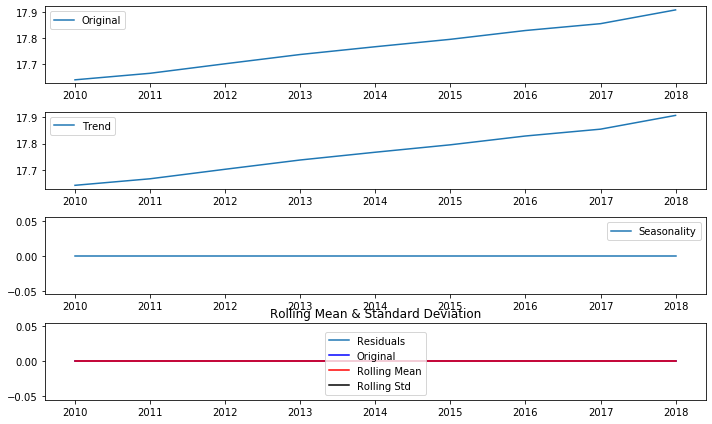

Results of Dickey-Fuller Test:


C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\statsmodels\regression\linear_model.py:889: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\statsmodels\base\model.py:1362: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\scipy\stats\_distn_infrastructure.py:1827: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(indexedDataset_logScale)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.subplot(411)
plt.plot(indexedDataset_logScale, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\statsmodels\tsa\stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


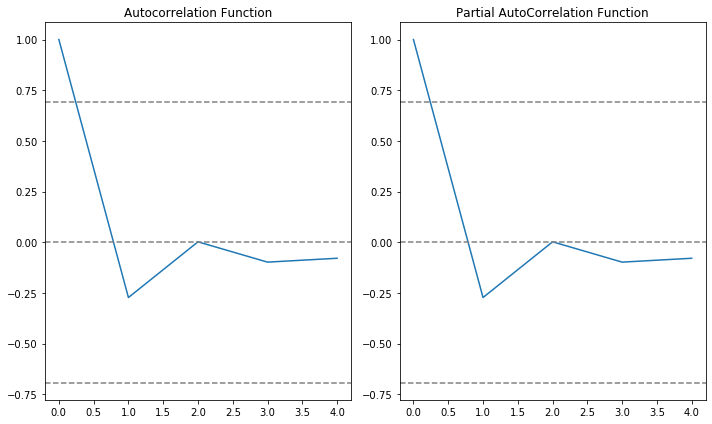

In [21]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(datasetLogDiffShifting, nlags=4)
lag_pacf = pacf(datasetLogDiffShifting, nlags=3, method='ols') #ordinary least square method

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial AutoCorrelation Function')
plt.tight_layout()


C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Potting AR model


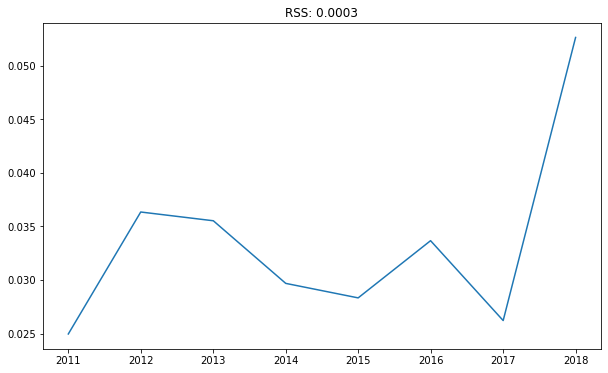

In [22]:
from statsmodels.tsa.arima_model import ARIMA

#AR MODEL
model = ARIMA(indexedDataset_logScale, order=(0,1,1))
results_AR = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting['Total'])**2))
print('Potting AR model')

C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0003')

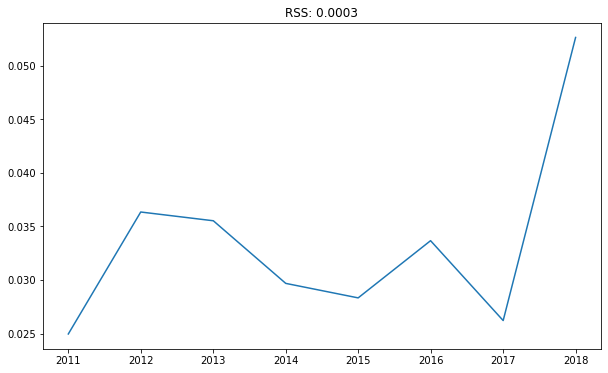

In [23]:
#MA MODEL
model =ARIMA(indexedDataset_logScale, order=(0,1,1))
results_MA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting['Total'])**2))

C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 0.0003')

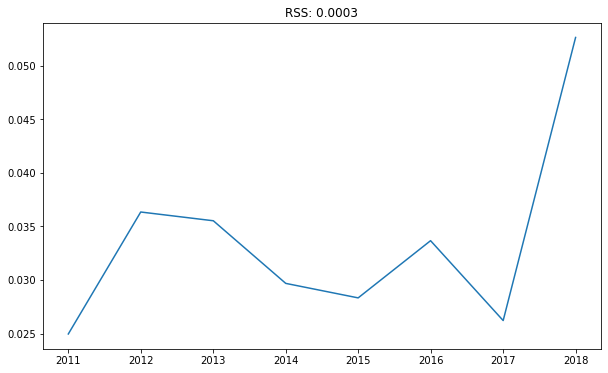

In [24]:
#ARIMA MODEL
model =ARIMA(indexedDataset_logScale, order=(0,1,1))
results_ARIMA = model.fit(disp=-1)
plt.plot(datasetLogDiffShifting)
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['Total'])**2))

In [25]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Year
2011-01-01    0.032513
2012-01-01    0.036292
2013-01-01    0.032483
2014-01-01    0.030235
2015-01-01    0.032959
dtype: float64


In [26]:
#Convert to cumulative sum
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

Year
2011-01-01    0.032513
2012-01-01    0.068805
2013-01-01    0.101288
2014-01-01    0.131523
2015-01-01    0.164482
dtype: float64


In [27]:
predictions_ARIMA_log =pd.Series(indexedDataset_logScale['Total'].ix[0], indexedDataset_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Users\ebaez\.conda\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Year
2010-01-01    17.640367
2011-01-01    17.672880
2012-01-01    17.709172
2013-01-01    17.741654
2014-01-01    17.771889
dtype: float64

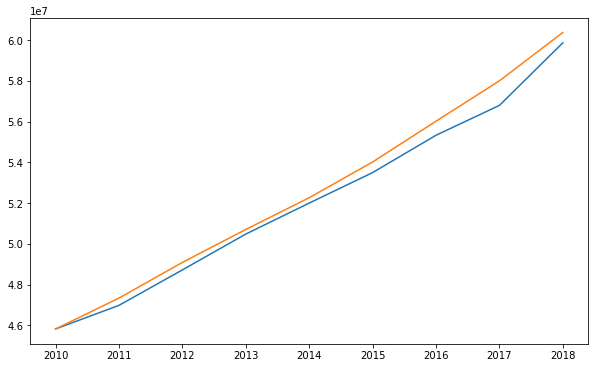

In [28]:
predictions_ARIMA= np.exp(predictions_ARIMA_log)
plt.plot(indexedDataset)
plt.plot(predictions_ARIMA)

In [29]:
indexedDataset_logScale

,Total
Year,
2010-01-01,17.640367
2011-01-01,17.665323
2012-01-01,17.701660
2013-01-01,17.737180
2014-01-01,17.766858
2015-01-01,17.795182
2016-01-01,17.828843
2017-01-01,17.855052
2018-01-01,17.907676


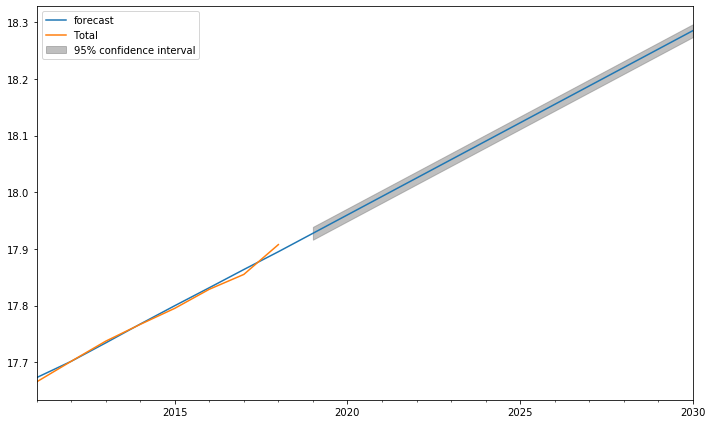

In [31]:
#for timeseries of 10 years
results_ARIMA.plot_predict(1,20) #comment out if you don't want to see the graph

# Save and show graph
plt.tight_layout()
plt.savefig("forecasted_Medicare_enrollment.png")
plt.show()


In [32]:
x = results_ARIMA.forecast(steps=10)

In [33]:
x[0]

array([17.92763069, 17.96014388, 17.99265707, 18.02517026, 18.05768345,
       18.09019663, 18.12270982, 18.15522301, 18.1877362 , 18.22024939])

In [34]:
len(x[0])

10

In [35]:
np.exp(x[0])

array([61076069.99589013, 63094482.45835756, 65179598.44102395,
       67333622.32960811, 69558831.3593034 , 71857578.02227199,
       74232292.5547008 , 76685485.5060485 , 79219750.39319971,
       81837766.44233243])